# Урок 6. Градиентный бустинг. AdaBoost

**План занятия**

* [Теоретическая часть](#theory)
    * [Градиентный бустинг (GBM)](#gbm)
        * [Алгоритм построения модели градиентного бустинга](#alg)
        * [Реализация алгоритма градиентного бустинга](#implement)
    * [AdaBoost](#ada)
        * [Алгоритм AdaBoost](#alg_ada)
        * [Реализация алгоритма AdaBoost](#implement_ada)
* [Домашнее задание](#hw)

## <center>Теоретическая часть<a class="anchor" id="theory"></a><center>

В этом уроке мы продолжаем тему ансамблей алгоритмов, рассматривая еще один их вид - _градиентный бустинг_. 

Вспоминая тему предыдущего урока, случайные леса, напомним, что случайный лес - это ансамбль деревьев небольшой глубины, строящихся независимо друг от друга. В независимости построения деревьев кроется и **плюс и минус алгоритма**: с одной стороны, построение деревьев можно **распараллеливать** и, например, организовывать на разных ядрах процессора, с другой стороны, следствием их независимости является тот факт, что для решения сложных задач требуется очень **большое количество деревьев**. В этих случаях случаях (при большой выборке или большом количестве признаков) обучение случайного леса может требовать очень много ресурсов, а если для ограничения их потребления слишком ограничивать глубину деревьев, они могут не уловить все закономерности в данных и иметь большой сдвиг (и, следовательно, ошибку).

**Бустинг** является своеобразным решением этой проблемы: он заключается в **последовательном** построении ансамбля, когда деревья строятся одно за другим, и при этом каждое следующее дерево строится таким образом, чтобы исправлять ошибки уже построенного на данный момент ансамбля. При таком подходе базовые алгоритмы могут быть достаточно простыми, то есть можно использовать неглубокие деревья.

<img src='images/boosting.png'>

## Градиентный бустинг (GBM)<a class='anchor' id='gbm'>
[Видео](https://youtu.be/sDv4f4s2SB8) с подробным объяснением алгоритма

**Продемонстрируем работу бустинга**

In [10]:
from sklearn.datasets import load_diabetes
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score


X, y = load_diabetes(return_X_y=True, as_frame=True)
X

D:\Install\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
D:\Install\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
D:\Install\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641
...,...,...,...,...,...,...,...,...,...,...
437,0.041708,0.050680,0.019662,0.059744,-0.005697,-0.002566,-0.028674,-0.002592,0.031193,0.007207
438,-0.005515,0.050680,-0.015906,-0.067642,0.049341,0.079165,-0.028674,0.034309,-0.018118,0.044485
439,0.041708,0.050680,-0.015906,0.017282,-0.037344,-0.013840,-0.024993,-0.011080,-0.046879,0.015491
440,-0.045472,-0.044642,0.039062,0.001215,0.016318,0.015283,-0.028674,0.026560,0.044528,-0.025930


In [11]:
y

0      151.0
1       75.0
2      141.0
3      206.0
4      135.0
       ...  
437    178.0
438    104.0
439    132.0
440    220.0
441     57.0
Name: target, Length: 442, dtype: float64

In [12]:
# Обучаем первое дерево
tree1 = DecisionTreeRegressor(max_depth=3,
                              random_state=2)
tree1.fit(X, y)

prediction1 = tree1.predict(X)
print(f'R2 score {r2_score(y, prediction1)}')

R2 score 0.5006720154703376


In [13]:
# Подсчитываем остатки
residual1 = y - prediction1
y[2], prediction1[2], residual1[2]

(141.0, 208.57142857142858, -67.57142857142858)

In [14]:
# Обучаем второе дерево на ошибках предыдущих
tree2 = DecisionTreeRegressor(max_depth=3,
                              random_state=2)

tree2.fit(X, residual1)

prediction2 = tree1.predict(X) + tree2.predict(X)
print(f'R2 score {r2_score(y, prediction2)}')

R2 score 0.5785866108916171


In [15]:
# Подсчитываем остатки
residual2 = y - prediction2
y[2], prediction2[2], residual2[2]

(141.0, 207.5052553799773, -66.50525537997731)

In [16]:
# Обучаем третье дерево на ошибках предыдущих
tree3 = DecisionTreeRegressor(max_depth=3,
                              random_state=2)

tree3.fit(X, residual2)

prediction3 = tree1.predict(X) + tree2.predict(X) + tree3.predict(X)
print(f'R2 score {r2_score(y, prediction3)}')

R2 score 0.6271203539706915


In [17]:
# Подсчитываем остатки
residual3 = y - prediction3
y[2], prediction3[2], residual3[2]

(141.0, 174.76070684814292, -33.76070684814292)

<img src='images/boosting_sum.png'>

**Алгоритм построения градиентного бустинга**
1. Инициализация начального алгоритма $b_{0}(x)$

2. Цикл по n = 1,2,3,...:

    * Подсчитывание остатков $s = \left ( \left.-\frac{\partial L}{\partial z} \right|_{z = a_{n-1}(x_{1})},...,\left.-\frac{\partial L}{\partial z} \right|_{z = a_{n-1}(x_{l})}\right );$

    * Обучение нового алгоритма $b_{n}(x) = \underset{s}{\text{argmin}}\frac{1}{l}\sum_{i=1}^{l}(b(x_{i})-s_{i})^{2};$
    
    * Добавление алгоритма в композицию $a_{n}(x) = a_{n-1}(x) + \eta b_{n}(x).$

Итоговый алгоритм ищется в виде взвешенной суммы базовых алгоритмов (обратите внимание: не среднего, а суммы):

$$a_{N}(x) = \sum^{N}_{n=1}b_{n}(x).$$

В случае регрессии задача состоит в минимизации среднеквадратичного функционала ошибки:

$$\frac{1}{l}\sum_{i=1}^{l}(a(x_{i}) - y_{i})^{2} \rightarrow \text{min}.$$

Так как ансамбль строится итеративно, нужно в начале обучить первый простой алгоритм:

$$b_{1}(x) = \underset{b}{\text{argmin}}\frac{1}{l}\sum_{i=1}^{l}(b(x_{i}) - y_{i})^{2}.$$

После того, как мы нашли первый алгоритм $b_{1}(x)$, нам нужно добавить в ансамбль еще один алгоритм $b_{2}(x)$. Для начала найдем разницу ответов первого алгоритма с реальными ответами:

$$s_{i}^{(1)} = y_{i} - b_{1}(x_{i}).$$

Если прибавить эти значения к полученным предсказаниям, получим идеальный ответ. Таким образом, новый алгоритм логично обучать так, чтобы его ответы были максимально близки к этой разнице, чтобы при их прибавлении к ответам первого алгоритма мы получили близкие к реальным. Значит, второй алгоритм будет обучаться на следующем функционале ошибки:

$$b_{2}(x) = \underset{b}{\text{argmin}}\frac{1}{l}\sum_{i=1}^{l}(b(x_{i}) - s_{i}^{(1)})^{2} = \underset{b}{\text{argmin}}\frac{1}{l}\sum_{i=1}^{l}(b(x_{i}) - (y_{i} - b_{1}(x_{i})))^{2}.$$

Каждый следующий алгоритм также настраивается на остатки композиции из предыдущих алгоритмов:

$$b_{N}(x) = \underset{b}{\text{argmin}}\frac{1}{l}\sum_{i=1}^{l}(b(x_{i}) - s_{i}^{(N)})^{2},$$ 

$$s_{i}^{(N)} = y_{i} - \sum_{n=1}^{N-1}b_{n}(x_{i}) = y_{i} - a_{N-1}(x_{i}).$$

Таким образом, каждый новый алгоритм корректирует ошибки предыдущих, и так продолжается до момента получения приемлемой ошибки на композиции. Вектор коэффициентов $s$ при этом называют _вектором сдвига_.

<img src="images/error.png" width=500px>

Выбор сдвига из условия $s_{i} = y_{i} - a_{N-1}(x_{i})$ требует точного совпадения полученных предсказаний и ответов, однако, в более общем случае вектор сдвига принимают с учетом особенностей используемой в данном случае функции потерь: вектор сдвига должен ее минимизировать, то есть направлять в сторону уменьшения. Как мы помним из метода градиентного спуска, направление наискорейшего убывания функции совпадает с ее антиградиентом. Таким образом, если при обучении мы минимизируем функционал ошибки $L(y,z)$

$$\sum_{i=1}^{l}L(y_{i}, a_{N-1}(x_{i}) + s_{i}) \rightarrow \underset{s}{\text{min}},$$

сдвиг на каждом шаге должен быть противоположен производной функции потерь в точке $z = a_{N-1}(x_{i})$. 

$$s_{i} = \left.-\frac{\partial L}{\partial z} \right|_{z = a_{N-1}(x_{i})}.$$

Каждый новый алгоритм таким образом выбирается так, чтобы как можно лучше приближать антиградиент ошибки на обучающей выборке. 

После того, как мы вычислили требуемый для минимизации ошибки сдвиг $s$, нужно настроить алгоритм $b_{N}(x)$ так, чтобы он давал максимально близкие к нему ответы, то есть обучать его именно на вектор сдвига. Близость ответов алгоритма к сдвигу обычно оценивается с помощью среднеквадратичной ошибки независимо от условий исходной задачи (так как исходно используемая функция потерь $L$ уже учтена в сдвигах $s_{i}$):

$$b_{N}(x) = \underset{s}{\text{argmin}}\frac{1}{l}\sum_{i=1}^{l}(b(x_{i})-s_{i})^{2}.$$

Обычно в качестве функции потерь в задачах регрессии принимается *квадратичная функция потерь* ($L_{2}$ loss):

$$L(y, z) = (y - z)^{2},$$

его **производная** по $z$ примет вид 

$$L'(y, z) = 2(z-y)$$

или модуль отклонения ($L_{1}$ loss)

$$L(y, z) = |y - z|,$$

его **производная** по $z$ будет иметь вид 

$$L'(y, z) = \text{sign}(z-y).$$

В случае классификации - логистическая функция потерь (метки -1, +1), где z - оценка принадлежности классу:

$$L(y, z) = log(1 + exp(-yz))$$

ее **производная**:

$$L'(y, z) = - \frac{y\cdot exp(-yz)}{1+exp(-yz)}.$$

Следует помнить, что компоненты $s$, вычисляемые через эти производные, берутся с минусом.

Аналогично алгоритму градиентного спуска, имеет смысл добавлять ответ каждого нового алгоритма не полностью, а с некоторым шагом $\eta \in (0, 1]$, так как базовые алгоритмы обычно достаточно простые (например, деревья малой глубины), и они могут плохо приближать вектор антиградиента, и тогда вместо приближения к минимуму мы будем получать случайное блуждание в пространстве. В градиентном бустинге такой прием называется сокращением шага.

$$a_{N}(x) = a_{N-1}(x) + \eta b_{N}(x).$$

Градиентный бустинг склонен к переобучению при увеличении числа итераций $N$ или глубины входящих в него деревьев. Стоит об этом помнить при построении алгоритма и выбирать оптимальные параметры по отложенной выборке или с помощью кросс-валидации.

### Алгоритм построения модели градиентного бустинга<a class='anchor' id='alg'>

__1.__ Для инициализации выбирается произвольный простой алгоритм $b_{0}(x)$, в его роли можно брать обычные константные алгоритмы: в случае задачи регрессии это может быть

$$b_{0}(x) = 0$$

или среднее значение по всем объектам обучающей выборки 

$$b_{0}(x) = \frac{1}{l}\sum_{i=1}^{l}y_{i};$$

в случае классификации - самый часто встречающийся в выборке класс

$$b_{0}(x) = \underset{y}{\text{argmax}}\sum_{i=1}^{l}[y_{i} = y].$$

__2.__ Для каждой итерации вычисляется вектор сдвига $s$:

$$s = \left ( \left.-\frac{\partial L}{\partial z} \right|_{z = a_{n-1}(x_{1})},...,\left.-\frac{\partial L}{\partial z} \right|_{z = a_{n-1}(x_{l})}\right );$$

находится алгоритм

$$b_{n}(x) = \underset{s}{\text{argmin}}\frac{1}{l}\sum_{i=1}^{l}(b(x_{i})-s_{i})^{2};$$

и добавляется в имеющийся ансамбль с умножением на шаг $\eta$, называемый _скоростью обучения_ (опционно)

$$a_{n}(x) = a_{n-1}(x) + \eta b_{n}(x).$$

__3.__ При достижении критериев остановки компонуется итоговая модель.

### Стохастический градиентный бустинг

Как и в случае с градиентым спуском, есть так называемый стохастический градиентный бустинг, являющийся упрощенной (в плане потребления ресурсов) версией алгоритма. Его суть заключается в обучении каждого нового базового алгоритма на новой итерации не на всей обучающей выборке, а на некоторой ее случайной подвыборке. Практика показывает, что такой алгоритм позволяет получить такую же ошибку или даже уменьшить ее при том же числе итераций, что и в случае использования обычного бустинга.

### Реализация алгоритма градиентного бустинга<a class='anchor' id='implement'>

Реализуем средствами Python алгоритм градиентного бустинга для деревьев решений.

Реализация деревьев решений была дважды продемонстрирована в предыдущих уроках, в этом не будем ее повторять и возьмем готовую реализацию дерева решений для регрессии из библиотеки `sklearn`.

In [18]:
from sklearn import model_selection
from sklearn.tree import DecisionTreeRegressor
from sklearn.datasets import load_diabetes
import matplotlib.pyplot as plt
import numpy as np

Используем один из "игрушечных" датасетов из той же библиотеки.

In [19]:
X, y = load_diabetes(return_X_y=True)
X.shape, y.shape

((442, 10), (442,))

Разделим выборку на обучающую и тестовую в соотношении 75/25.

In [20]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

Напишем функцию, реализующую предсказание в градиентном бустинге.

In [21]:
def gb_predict(X, trees_list, eta):
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании
    # прибавляются с шагом eta
    
    predictions = np.zeros(X.shape[0])
    for i, x in enumerate(X):
        prediction = 0
        for alg in trees_list:
            prediction += eta * alg.predict([x])[0]
        predictions[i] = prediction
        
#     predictions = np.array(
#         [sum([eta * alg.predict([x])[0] for alg in trees_list]) for x in X]
#     )

    return predictions

In [22]:
def gb_predict_improved(X, tree, eta, prev_predictions):
    
    if not any(prev_predictions):
        for i, x in enumerate(X):
            prev_predictions[i] += eta * tree.predict([x])[0] 
    else:
        for i, x in enumerate(X):
            prev_predictions[i] += eta * tree.predict([x])[0]
    
    return prev_predictions

In [23]:
X_train.shape

(331, 10)

В качестве функционала ошибки будем использовать среднеквадратичную ошибку. Реализуем соответствующую функцию.

In [24]:
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)

Используем $L_{2}$ loss $L(y, z) = (y - z)^{2},$ ее производная по $z$ примет вид $L'(y, z) = 2(z - y)$. Реализуем ее также в виде функции (коэффициент 2 можно отбросить).

In [25]:
def residual(y, z):
    return - (z - y)

Реализуем функцию обучения градиентного бустинга.

In [26]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, residual(y_train, target))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

In [28]:
def gb_fit_improved(n_trees, max_depth, X_train, X_test, y_train, y_test, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    train_pred = np.zeros(X_train.shape[0])
    test_pred = np.zeros(X_test.shape[0])
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_pred = gb_predict_improved(X_train, tree, eta, train_pred)
            test_pred = gb_predict_improved(X_test, tree, eta, test_pred)
            
            train_errors.append(mean_squared_error(y_train, train_pred))
            test_errors.append(mean_squared_error(y_test, test_pred))
        else:
#             # Получим ответы на текущей композиции
#             target = gb_predict(X_train, trees, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, residual(y_train, train_pred))
            
            train_pred = gb_predict_improved(X_train, tree, eta, train_pred)
            test_pred = gb_predict_improved(X_test, tree, eta, test_pred)          
            
            train_errors.append(mean_squared_error(y_train, train_pred))
            test_errors.append(mean_squared_error(y_test, test_pred))

        trees.append(tree)
        
    return trees, train_errors, test_errors

In [36]:
from itertools import product
eta = 0.1

n_trees_list = [1, 5, 25, 50]
max_depth_list = [3, 5, 10]

results_list = np.zeros([len([(x, y) for x, y in product(n_trees_list, max_depth_list)]), 3])
iterator = 0

for n_trees, max_depth in product(n_trees_list, max_depth_list):
    trees, _, _ = gb_fit_improved(n_trees, max_depth, X_train, X_test, y_train, y_test, eta)
    
    test_prediction = gb_predict(X_test, trees, eta)
    
    results_list[iterator, :] = (n_trees, max_depth, mean_squared_error(y_test, test_prediction))
    
    iterator += 1

In [37]:
results_list

array([[1.00000000e+00, 3.00000000e+00, 2.51198649e+04],
       [1.00000000e+00, 5.00000000e+00, 2.51288826e+04],
       [1.00000000e+00, 1.00000000e+01, 2.50340703e+04],
       [5.00000000e+00, 3.00000000e+00, 1.30215806e+04],
       [5.00000000e+00, 5.00000000e+00, 1.33660949e+04],
       [5.00000000e+00, 1.00000000e+01, 1.32986543e+04],
       [2.50000000e+01, 3.00000000e+00, 3.51251904e+03],
       [2.50000000e+01, 5.00000000e+00, 4.27938848e+03],
       [2.50000000e+01, 1.00000000e+01, 5.54616911e+03],
       [5.00000000e+01, 3.00000000e+00, 3.31694859e+03],
       [5.00000000e+01, 5.00000000e+00, 4.28570431e+03],
       [5.00000000e+01, 1.00000000e+01, 5.56529976e+03]])

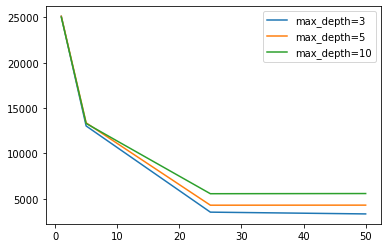

In [38]:

for max_depth in max_depth_list:
    plt.plot(results_list[np.where(results_list[:,1] == max_depth)][:,0], results_list[np.where(results_list[:,1] == max_depth)][:,2], label=f'max_depth={max_depth}')
    plt.xlabel = 'n_trees'
    plt.ylabel = 'MSE'
    plt.legend()

In [129]:
from random import sample

def stochastic_gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta, fraction=0.5):
    # Деревья будем записывать в список
    trees = []
    X_tr_len = X_train.shape[0]
    X_ts_len = X_test.shape[0]
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    train_pred = np.zeros(X_tr_len)
    test_pred = np.zeros(X_ts_len)
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_pred = gb_predict_improved(X_train, tree, eta, train_pred)
            test_pred = gb_predict_improved(X_test, tree, eta, test_pred)
            
            train_errors.append(mean_squared_error(y_train, train_pred))
            test_errors.append(mean_squared_error(y_test, test_pred))
        else:
            sample_indexes = sample(range(X_tr_len), int(X_tr_len * fraction))
            X_train_part = X_train[sample_indexes, :]
            y_train_part = y_train[sample_indexes]
            train_pred_part = train_pred[sample_indexes]
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train_part, residual(y_train_part, train_pred_part))
            
            train_pred = gb_predict_improved(X_train, tree, eta, train_pred)
            test_pred = gb_predict_improved(X_test, tree, eta, test_pred)          
            
            train_errors.append(mean_squared_error(y_train, train_pred))
            test_errors.append(mean_squared_error(y_test, test_pred))

        trees.append(tree)
        
    return trees, train_errors, test_errors

Теперь обучим несколько моделей с разными параметрами и исследуем их поведение.

In [38]:
%%time

# Число деревьев в ансамбле
n_trees = 20

# Максимальная глубина деревьев
max_depth = 3

# Шаг
eta = 1

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta)

Wall time: 7.82 s


In [131]:
%%time
trees_imp, train_errors_imp, test_errors_imp = gb_fit_improved(n_trees, max_depth, X_train, X_test, y_train, y_test, eta)

Wall time: 1.23 s


In [132]:
%%time
trees_st, train_errors_st, test_errors_st = stochastic_gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta)

Wall time: 1.25 s


In [133]:
def evaluate_alg(X_train, X_test, y_train, y_test, trees, eta):
    train_prediction = gb_predict(X_train, trees, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тренировочной выборке: {mean_squared_error(y_train, train_prediction)}')

    test_prediction = gb_predict(X_test, trees, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тестовой выборке: {mean_squared_error(y_test, test_prediction)}')

In [135]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, eta)
evaluate_alg(X_train, X_test, y_train, y_test, trees_imp, eta)
evaluate_alg(X_train, X_test, y_train, y_test, trees_st, eta)

Ошибка алгоритма из 50 деревьев глубиной 5     с шагом 0.1 на тренировочной выборке: 350.9149576804654
Ошибка алгоритма из 50 деревьев глубиной 5     с шагом 0.1 на тестовой выборке: 3534.6753687477526
Ошибка алгоритма из 50 деревьев глубиной 5     с шагом 0.1 на тренировочной выборке: 350.9149576804654
Ошибка алгоритма из 50 деревьев глубиной 5     с шагом 0.1 на тестовой выборке: 3534.6753687477526
Ошибка алгоритма из 50 деревьев глубиной 5     с шагом 0.1 на тренировочной выборке: 504.91465118450645
Ошибка алгоритма из 50 деревьев глубиной 5     с шагом 0.1 на тестовой выборке: 3297.6566253936235


Построим графики зависимости ошибки на обучающей и тестовой выборках от числа итераций.

In [20]:
def get_error_plot(n_trees, train_err, test_err):
    plt.xlabel('Iteration number')
    plt.ylabel('MSE')
    plt.xlim(0, n_trees)
    plt.plot(list(range(n_trees)), train_err, label='train error')
    plt.plot(list(range(n_trees)), test_err, label='test error')
    plt.legend(loc='upper right')
    plt.show()

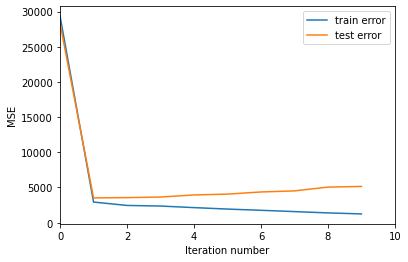

In [21]:
get_error_plot(n_trees, train_errors, test_errors)

Такой результат не является удовлетворительным

Увеличим число деревьев.

In [21]:
%%time
n_trees = 50

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta)

CPU times: user 1min 42s, sys: 600 ms, total: 1min 43s
Wall time: 1min 44s


In [60]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, eta)

Ошибка алгоритма из 50 деревьев глубиной 3     с шагом 1 на тренировочной выборке: 70.43861643653375
Ошибка алгоритма из 50 деревьев глубиной 3     с шагом 1 на тестовой выборке: 5513.332418598973


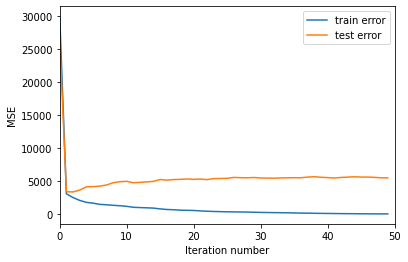

In [61]:
get_error_plot(n_trees, train_errors, test_errors)

Теперь попробуем уменьшить шаг.

In [62]:
%%time
eta = 0.1

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta)

CPU times: user 3min 15s, sys: 152 ms, total: 3min 15s
Wall time: 3min 16s


In [63]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, eta)

Ошибка алгоритма из 50 деревьев глубиной 3     с шагом 0.1 на тренировочной выборке: 1522.5895529378424
Ошибка алгоритма из 50 деревьев глубиной 3     с шагом 0.1 на тестовой выборке: 2874.4849477323646


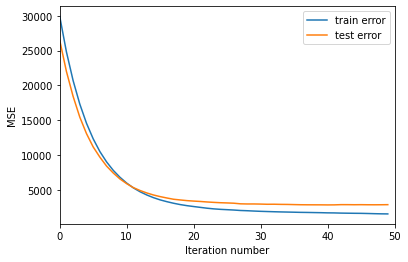

In [64]:
get_error_plot(n_trees, train_errors, test_errors)

Видим, что качество обучения улучшается.

Уменьшим шаг до 0.01.

In [65]:
%%time
eta = 0.01

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta)

CPU times: user 3min 17s, sys: 164 ms, total: 3min 17s
Wall time: 3min 17s


In [66]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, eta)

Ошибка алгоритма из 50 деревьев глубиной 3     с шагом 0.01 на тренировочной выборке: 12801.091549463747
Ошибка алгоритма из 50 деревьев глубиной 3     с шагом 0.01 на тестовой выборке: 11578.276199882108


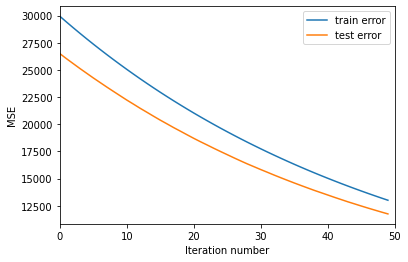

In [67]:
get_error_plot(n_trees, train_errors, test_errors)

При таком размере шага алгоритм сходится, но ему для достижения удовлетворительных показателей требуется большее количество итераций.

Вернемся к шагу 0.1 и попробуем увеличить глубину деревьев

In [47]:
%%time
eta = 0.1
max_depth = 5

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta)

Wall time: 48.5 s


In [44]:
%%time
eta = 0.1
max_depth = 5
n_trees = 50

trees_imp, train_errors_imp, test_errors_imp = gb_fit_improved(n_trees, max_depth, X_train, X_test, y_train, y_test, eta)

Wall time: 1.26 s


In [48]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, eta)
evaluate_alg(X_train, X_test, y_train, y_test, trees_imp, eta)

Ошибка алгоритма из 50 деревьев глубиной 5     с шагом 0.1 на тренировочной выборке: 350.9149576804654
Ошибка алгоритма из 50 деревьев глубиной 5     с шагом 0.1 на тестовой выборке: 3534.6753687477526
Ошибка алгоритма из 50 деревьев глубиной 5     с шагом 0.1 на тренировочной выборке: 350.9149576804654
Ошибка алгоритма из 50 деревьев глубиной 5     с шагом 0.1 на тестовой выборке: 3534.6753687477526


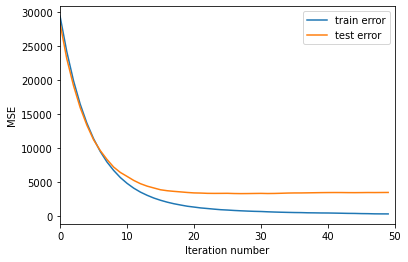

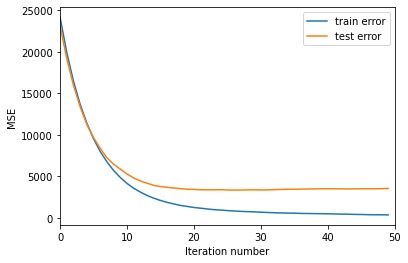

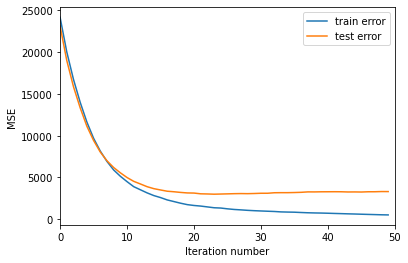

In [136]:
get_error_plot(n_trees, train_errors, test_errors)
get_error_plot(n_trees, train_errors_imp, test_errors_imp)
get_error_plot(n_trees, train_errors_st, test_errors_st)

Ошибка на обучающей выборке упала, а на тестовой несколько поднялась, то есть в данном случае можем говорить о появлении переобучения.

В целом, тут мы показали, что варьируя параметры обучения градиентного бустинга можно добиваться различного уровня точности модели.

Существуют различные реализации градиентного бустинга, и одна из самых популярных и широко используемых - XGBoost (в Python содержится в библиотеке с аналогичным названием). С этой реализацией можно ознакомиться в дополнительных материалах.

## AdaBoost<a class='anchor' id='ada'>
[Видео](https://www.youtube.com/watch?v=LsK-xG1cLYA) с подробным объяснением алгоритма

Для задачи бинарной классификации он заключается в использовании слабых классификаторов (например, деревьев глубиной 1 - так называемых "пней") в цикле, с придаванием объектам весов. После каждого шага итерации, когда разделяющая плоскость классификатора делит пространство объектов на две части, веса объектов перераспределяются, и веса неправильно классифицированных объектов увеличиваются, чтобы на следующей итерации классификатор акцентировался на этих объектах. Классификатору также присваивается вес в зависимости от его точности. Затем полученные деревья с весами объединяются в один сильный классификатор. В этом и заключается адаптивность алгоритма. Алгоритм AdaBoost также называют алгоритмом усиления классификаторов.

**Продемонстрируем работу AdaBoost**

In [21]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.datasets import load_breast_cancer

In [68]:
X, y = load_breast_cancer(return_X_y=True, as_frame=True)
X.shape, y.shape

((569, 30), (569,))

In [69]:
np.random.seed(6)
index = np.random.randint(0, X.shape[0], 1)
X_test = X.loc[index]
y_test = y.loc[index]

In [24]:
X.columns

Index(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error', 'fractal dimension error',
       'worst radius', 'worst texture', 'worst perimeter', 'worst area',
       'worst smoothness', 'worst compactness', 'worst concavity',
       'worst concave points', 'worst symmetry', 'worst fractal dimension'],
      dtype='object')

In [70]:
X = X.loc[[ 41,  44,  73,  81,  89,  91, 135, 146, 484, 491]]
y = y.loc[[ 41,  44,  73,  81,  89,  91, 135, 146, 484, 491]]
X

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
41,10.95,21.35,71.90,371.1,0.12270,0.12180,0.10440,0.05669,0.1895,0.06870,...,12.84,35.34,87.22,514.0,0.19090,0.26980,0.4023,0.14240,0.2964,0.09606
44,13.17,21.81,85.42,531.5,0.09714,0.10470,0.08259,0.05252,0.1746,0.06177,...,16.23,29.89,105.50,740.7,0.15030,0.39040,0.3728,0.16070,0.3693,0.09618
73,13.80,15.79,90.43,584.1,0.10070,0.12800,0.07789,0.05069,0.1662,0.06566,...,16.57,20.86,110.30,812.4,0.14110,0.35420,0.2779,0.13830,0.2589,0.10300
81,13.34,15.86,86.49,520.0,0.10780,0.15350,0.11690,0.06987,0.1942,0.06902,...,15.53,23.19,96.66,614.9,0.15360,0.47910,0.4858,0.17080,0.3527,0.10160
89,14.64,15.24,95.77,651.9,0.11320,0.13390,0.09966,0.07064,0.2116,0.06346,...,16.34,18.24,109.40,803.6,0.12770,0.30890,0.2604,0.13970,0.3151,0.08473
91,15.37,22.76,100.20,728.2,0.09200,0.10360,0.11220,0.07483,0.1717,0.06097,...,16.43,25.84,107.50,830.9,0.12570,0.19970,0.2846,0.14760,0.2556,0.06828
135,12.77,22.47,81.72,506.3,0.09055,0.05761,0.04711,0.02704,0.1585,0.06065,...,14.49,33.37,92.04,653.6,0.14190,0.15230,0.2177,0.09331,0.2829,0.08067
146,11.80,16.58,78.99,432.0,0.10910,0.17000,0.16590,0.07415,0.2678,0.07371,...,13.74,26.38,91.93,591.7,0.13850,0.40920,0.4504,0.18650,0.5774,0.10300
484,15.73,11.28,102.80,747.2,0.10430,0.12990,0.11910,0.06211,0.1784,0.06259,...,17.01,14.20,112.50,854.3,0.15410,0.29790,0.4004,0.14520,0.2557,0.08181
491,17.85,13.23,114.60,992.1,0.07838,0.06217,0.04445,0.04178,0.1220,0.05243,...,19.82,18.42,127.10,1210.0,0.09862,0.09976,0.1048,0.08341,0.1783,0.05871


In [26]:
y

41     0
44     0
73     0
81     1
89     1
91     0
135    0
146    0
484    1
491    1
Name: target, dtype: int64

__1.__ Инициализация начальных весов объектов из выборки длиной $l$:

$$D_{1}(i) = \frac{1}{l}$$

In [27]:
n_objects = X.shape[0]
w = np.ones(n_objects) / n_objects
w

array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])

__2.__ Для каждого из $N$ деревьев в ансамбле:

- находим классификатор $b_{n}$, который минимизирует взвешенную ошибку классификации

$$b_{n} = \underset{b}{\text{argmin}}\;\varepsilon_{j},$$

    где 

$$\varepsilon_{j} = \sum_{i=1}^{l}D_{n}(i)[y_{i}\neq b_{j}(x)]$$

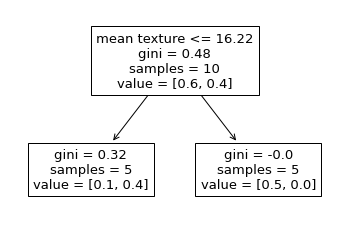

In [28]:
stump1 = DecisionTreeClassifier(max_depth=1, random_state=1)
stump1.fit(X, y, sample_weight=w)

pred = stump1.predict(X)
plot_tree(stump1, feature_names=X.columns, );

In [29]:
pred == y

41      True
44      True
73     False
81      True
89      True
91      True
135     True
146     True
484     True
491     True
Name: target, dtype: bool

In [30]:
error1 = sum(pred != y) / len(y)
error1

0.1

- критерием остановки является значение $\varepsilon_{j} \geq 0.5$. При таком значении ошибки нужно выбрать другой классификатор и продолжить.

- выбираем вес для дерева $\alpha_{n}$ по формуле

$$\alpha_{n} = \frac{1}{2}\text{ln}\frac{1 - \varepsilon_{n}}{\varepsilon_{n}}$$


In [31]:
def amount_of_say(x):
    return 1/2 * np.log((1 - x) / x)

<ipython-input-31-d4f702aa4b94>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 1/2 * np.log((1 - x) / x)
<ipython-input-31-d4f702aa4b94>:2: RuntimeWarning: divide by zero encountered in log
  return 1/2 * np.log((1 - x) / x)


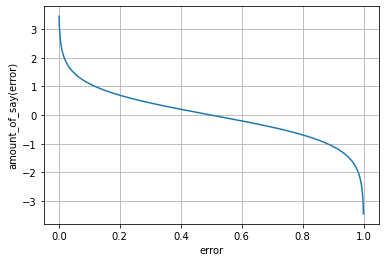

In [32]:
dots = np.linspace(0, 1, 1000)
amount_of_say_value = list(map(amount_of_say, dots))

plt.xlabel('error')
plt.ylabel('amount_of_say(error)')
plt.grid()
plt.plot(dots, amount_of_say_value);

**Получим вес для пня**

In [33]:
alpha1 = 1/2 * np.log((1 - error1) / error1)
alpha1

1.0986122886681098

- обновляем веса при объектах:
$$D_i = D_{i-1}e^{\alpha_i} - \text{изменение веса одного объекта при неверной классификации} $$

In [34]:
def new_sample_weight(x):
    return np.exp(x)

In [72]:
0.1 * np.exp(3.5)

3.3115451958692312

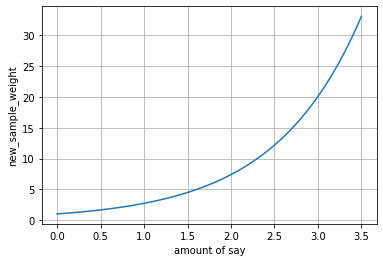

In [36]:
dots = np.linspace(0, 3.5, 1000)
new_sample_weight_value = list(map(new_sample_weight, dots))

plt.xlabel('amount of say')
plt.ylabel('new_sample_weight')
plt.grid()
plt.plot(dots, new_sample_weight_value);

Если пень сделал не очень хорошую классификацию, то вес объекта станет немного больше, если пень сделал хорошую классификацию, то вес объекта станет больше.

**Меняем вес неверное классифицированного объекта**

In [37]:
wrong_mask = pred != y
w[wrong_mask] = w[wrong_mask] * np.exp(alpha1)
w

array([0.1, 0.1, 0.3, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])

$$D_i = D_{i-1}e^{-\alpha_i} - \text{изменение веса одного объекта при верной классификации} $$

In [38]:
def new_sample_weight(x):
    return np.exp(-x)

In [73]:
0.1 * np.exp(-3.5)

0.00301973834223185

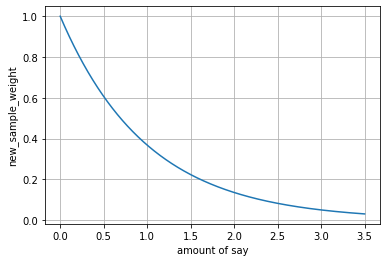

In [40]:
dots = np.linspace(0, 3.5, 1000)
new_sample_weight_value = list(map(new_sample_weight, dots))

plt.xlabel('amount of say')
plt.ylabel('new_sample_weight')
plt.grid()
plt.plot(dots, new_sample_weight_value);

Если пень сделал не очень хорошую классификацию, то вес объекта станет меньше, если пень сделал хорошую классификацию, то вес объекта станет немного меньше.

То есть, те объекты, которые хорошо классифицируются будут иметь меньший вес, чем те, на которых классификатор ошибается.

**Меняем веса верно классифицированных объектов**

In [41]:
w[~wrong_mask] = w[~wrong_mask] * np.exp(-alpha1)
w

array([0.03333333, 0.03333333, 0.3       , 0.03333333, 0.03333333,
       0.03333333, 0.03333333, 0.03333333, 0.03333333, 0.03333333])

In [42]:
sum(w)

0.6

In [43]:
w /= sum(w)

In [44]:
w

array([0.05555556, 0.05555556, 0.5       , 0.05555556, 0.05555556,
       0.05555556, 0.05555556, 0.05555556, 0.05555556, 0.05555556])

In [45]:
sum(w)

1.0000000000000002

**Обучим следующий пень**

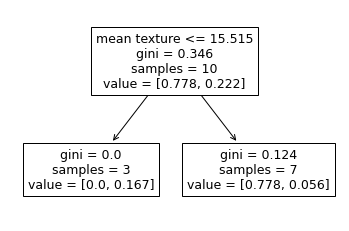

In [46]:
stump2 = DecisionTreeClassifier(max_depth=1, random_state=1)
stump2.fit(X, y, sample_weight=w)

pred = stump2.predict(X)
plot_tree(stump2, feature_names=X.columns);

In [47]:
pred != y

41     False
44     False
73     False
81      True
89     False
91     False
135    False
146    False
484    False
491    False
Name: target, dtype: bool

In [48]:
error2 = sum(pred != y) / len(y)
alpha2 = 1/2 * np.log((1 - error2) / error2)

wrong_mask = pred != y
w[wrong_mask] = w[wrong_mask] * np.exp(alpha2)

w[~wrong_mask] = w[~wrong_mask] * np.exp(-alpha2)
w /= sum(w)
w

array([0.03846154, 0.03846154, 0.34615385, 0.34615385, 0.03846154,
       0.03846154, 0.03846154, 0.03846154, 0.03846154, 0.03846154])

**Обучим следующий пень**

In [49]:
stump3 = DecisionTreeClassifier(max_depth=1, random_state=1)
stump3.fit(X, y, sample_weight=w)

pred = stump3.predict(X)
error3 = sum(pred != y) / len(y)
alpha3 = 1/2 * np.log((1 - error3) / error3)

wrong_mask = pred != y
w[wrong_mask] = w[wrong_mask] * np.exp(alpha3)

w[~wrong_mask] = w[~wrong_mask] * np.exp(-alpha3)
w /= sum(w)
w

array([0.03125, 0.03125, 0.28125, 0.28125, 0.125  , 0.03125, 0.03125,
       0.03125, 0.03125, 0.125  ])

In [50]:
wrong_mask

41     False
44     False
73     False
81     False
89      True
91     False
135    False
146    False
484    False
491     True
Name: target, dtype: bool

**Предскажем классы объектов с помощью трех пней**

In [51]:
display(X_test, y_test)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
227,15.0,15.51,97.45,684.5,0.08371,0.1096,0.06505,0.0378,0.1881,0.05907,...,16.41,19.31,114.2,808.2,0.1136,0.3627,0.3402,0.1379,0.2954,0.08362


227    1
Name: target, dtype: int64

In [52]:
alpha1, alpha2, alpha3

(1.0986122886681098, 1.0986122886681098, 0.6931471805599453)

In [53]:
pred1 = stump1.predict(X_test)
pred2 = stump2.predict(X_test)
pred3 = stump3.predict(X_test)
pred1, pred2, pred3

(array([1]), array([1]), array([0]))

In [54]:
alpha1 + alpha2, alpha3

(2.1972245773362196, 0.6931471805599453)

In [55]:
pred = 1
y_test

227    1
Name: target, dtype: int64

## Алгоритм AdaBoost<a class='anchor' id='alg_ada'>

__1.__ Инициализация начальных весов объектов из выборки длиной $l$ (равномерно):

$$D_{1}(i) = \frac{1}{l}$$

__2.__ Для каждого из $N$ деревьев в ансамбле:

- находим классификатор $b_{n}$, который минимизирует взвешенную ошибку классификации

$$b_{n} = \underset{b}{\text{argmin}}\;\varepsilon_{j},$$

    где 

$$\varepsilon_{j} = \sum_{i=1}^{l}D_{n}(i)[y_{i}\neq b_{j}(x)]$$
$D_{n}(i)$ - вес объекта, $[y_{i}\neq b_{j}(x)]$ - неправильно классифицированные объекты

- критерием остановки является значение $\varepsilon_{j} \geq 0.5$. При таком значении ошибки нужно выбрать другой классификатор и продолжить.

- выбираем вес для дерева $\alpha_{n}$ по формуле

$$\alpha_{n} = \frac{1}{2}\text{ln}\frac{1 - \varepsilon_{n}}{\varepsilon_{n}}$$

- обновляем веса при объектах:

$$D_{n+1}(i) = \frac{D_{n}(i)e^{-\alpha_{n}y_{i}b_{n}(x_{i})}}{Z_{n}},$$

выражение $y_{i}b_{n}(x_{i})$ в случае $Y = \{-1, 1\}$ будет равняться 1 для правильно классифицированных объектов и -1 для неправильно классифицированных, то есть по сути правильность классификации будет означать, будет $e^{\alpha_{n}}$ стоять в числителе (увеличивается вес неправильно классиф. объектов) или в знаменателе (уменьшается вес правильно классиф. объектов) формулы. В случае $Y = \{0,1\}$ вес будет уменьшаться у правильно классифицированных объектов, а у неправильно классифицированных - оставаться неизменным (до нормализации). $Z_{n}$ здесь - нормализующий параметр, выбираемый так, чтобы $D_{n+1}$ по своей сути являлся распределением вероятностей, то есть

$$\sum_{i=1}^{l}D_{n+1} = 1.$$

### Реализация алгоритма AdaBoost<a class='anchor' id='implement_ada'>

In [56]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_breast_cancer

In [57]:
X, y = load_breast_cancer(return_X_y=True)
X.shape, y.shape

((569, 30), (569,))

Разделим выборку на обучающую и тестовую

In [58]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25, random_state=32)

Реализуем функцию подсчета ошибки

In [59]:
def get_error(pred, y):
    return sum(pred != y) / len(y)

И сам алгоритм

In [60]:
def adaboost(X, y, N):

    # Размер выборки
    n_objects = len(X)

    # Запишем количество классов в переменную
    n_classes = len(np.unique((y)))

    # Начальные веса объектов
    w = np.ones(n_objects) / n_objects

    # Деревья с весами будем записывать в список
    models = []

    for n in range(N):
        # Зададим дерево и обучим его
        clf = DecisionTreeClassifier(max_depth=1)
        clf.fit(X, y, sample_weight=w)

        predictions = clf.predict(X)
        error = get_error(predictions, y)
        
        # отбросим дерево, если его ошибка больше 0.5
        # Запишем условие в общем виде (применимо к небинарным классификаторам)
        if error >= 1 - 1/n_classes: 
            continue

        # Обработаем граничные значения ошибок
        if error == 0:
            error += 1e-10
   
        # Вычислим вес для дерева
        alpha = 0.5 * np.log((1 - error) / error)


        # Найдем индексы правильно классифицированных элементов
        wrong_mask = predictions != y

        # Увеличим веса для неправильно классифицированных элементов
        w[wrong_mask] *= np.exp(alpha)
        # Уменьшаем веса для правильно классифицированных элементов
        w[~wrong_mask] *= np.exp(-alpha)

        # Нормализуем веса
        w /= w.sum()

        # Добавим дерево с весом в список
        models.append((alpha, clf))
    
    return models

Обучим алгоритм из 50 деревьев

In [61]:
N = 50

models = adaboost(X_train, y_train, N)

Теперь осуществим предсказание

In [62]:
np.zeros((10, 2))

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]])

In [63]:
def predict(X, models):
    
    n_classes = 2
    n_objects = len(X)
    
    # вначале обозначим предсказание нулевым массивом
    y_pred = np.zeros((n_objects, n_classes))
    
    for alpha, clf in models:
        prediction = clf.predict(X)
        # Для каждого предсказания будем прибавлять alpha к
        # элементу с индексом предсказанного класса
        y_pred[range(n_objects), prediction] += alpha
    
    # выберем индексы с максимальными суммарными весами -
    # получим предсказанные алгоритмом классы
    y_pred = np.argmax(y_pred, axis=1)
    
    return y_pred

In [64]:
print(f'Точность алгоритма на обучающей выборке: {(1 - get_error(predict(X_train, models), y_train)) * 100:.3f}')

Точность алгоритма на обучающей выборке: 96.948


In [65]:
print(f'Точность алгоритма на тестовой выборке: {(1 - get_error(predict(X_test, models), y_test)) * 100:.3f}')

Точность алгоритма на тестовой выборке: 94.406


Построим графики зависимости ошибки от количества базовых алгоритмов в ансамбле.

In [66]:
train_errors = []
test_errors = []

for n in range(1, 31):
    models = adaboost(X_train, y_train, n)
    train_errors.append(get_error(predict(X_train, models), y_train))
    test_errors.append(get_error(predict(X_test, models), y_test))

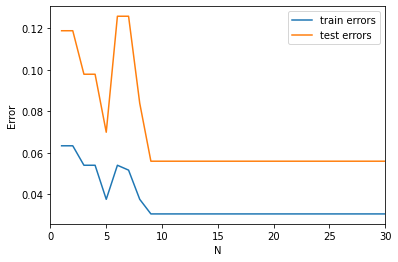

In [67]:
x = list(range(1, 31))

plt.xlim(0, 30)
plt.plot(x, train_errors, label='train errors')
plt.plot(x, test_errors, label='test errors')
plt.xlabel('N')
plt.ylabel('Error')
plt.legend(loc='upper right');

Достоинствами алгоритма AdaBoost можно назвать простоту реализации, хорошую обобщающую способность и небольшую вычислительную сложность. В то же время, есть и недостатки - в первую очередь, склонность к переобучению при наличии в данных шума и выбросов: для наиболее трудноклассифицируемых объектов алгоритм будет определять очень большие веса и в итоге переобучаться на них. В то же время это является и плюсом: таким образом можно идентифицировать выбросы. 

## Домашнее задание<a class='anchor' id='hw'>

1. Для реализованной модели градиентного бустинга построить графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев. Сделать выводы о зависимости ошибки от этих параметров.

2. *Модифицировать реализованный алгоритм градиентного бустинга, чтобы получился стохастический градиентный бустинг. Размер подвыборки принять равным 0.5. Сравнить на одном графике кривые изменения ошибки на тестовой выборке в зависимости от числа итераций.(Сделано, но надо оформить)

3. *Оптимизировать процесс обучения градиентного бустинга, чтобы он занимал меньше времени. (СДЕЛАНО)

Проект*: 
1. https://www.kaggle.com/c/gb-tutors-expected-math-exam-results регрессия
1. https://www.kaggle.com/c/gb-choose-tutors классификация

## Дополнительные материалы

1. [Интерактивная демонстрация градиентного бустинга](http://arogozhnikov.github.io/2016/06/24/gradient_boosting_explained.html)
2. [sklearn.datasets](https://scikit-learn.org/stable/datasets/index.html)
3. [sklearn.tree.DecisionTreeRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html)
4. [$L_{1}$ loss и $L_{2}$ loss](https://afteracademy.com/blog/what-are-l1-and-l2-loss-functions)
5. [XGBoost](https://github.com/esokolov/ml-course-hse/blob/master/2016-fall/lecture-notes/lecture10-ensembles.pdf)
6. [AdaBoost](https://ru.wikipedia.org/wiki/AdaBoost)
7. [XGBoost: A Scalable Tree Boosting System - оригинальная статья](http://scholar.google.ru/scholar_url?url=https://dl.acm.org/ft_gateway.cfm%3Fftid%3D1775849%26id%3D2939785&hl=en&sa=X&scisig=AAGBfm3b8fqJWtjjjejQ5fQwrtg9eQQK-w&nossl=1&oi=scholarr)

## Summary

* На больших и сложных данных градиентный бустинг - один из лучших алгоритмов
* Много настраиваемых параметров 
* Есть очень быстрые реализации 
* Обычно строят на деревьях решений

### Определения
*Бустинг*

**Бустинг** — это техника построения ансамблей, в которой предсказатели построены не независимо, а последовательно.

**Алгоритм построения градиентного бустинга**
1. Инициализация начального алгоритма $b_{0}(x)$

2. Цикл по n = 1,2,3,...:

    * Подсчитывание остатков $s = \left ( \left.-\frac{\partial L}{\partial z} \right|_{z = a_{n-1}(x_{1})},...,\left.-\frac{\partial L}{\partial z} \right|_{z = a_{n-1}(x_{l})}\right );$

    * Обучение нового алгоритма $b_{n}(x) = \underset{s}{\text{argmin}}\frac{1}{l}\sum_{i=1}^{l}(b(x_{i})-s_{i})^{2};$
    
    * Добавление алгоритма в композицию $a_{n}(x) = a_{n-1}(x) + \eta b_{n}(x).$

**Алгоритм построения AdaBoost**
1. Инициализация начальных весов объектов:
$D_{1}(i) = \frac{1}{l}$
2. Цикл по n = 1,2,3,...:

    * находим классификатор $b_{n}$, который минимизирует взвешенную ошибку классификации
$b_{n} = \underset{b}{\text{argmin}}\;\varepsilon_{j},$    где 
$\varepsilon_{j} = \sum_{i=1}^{l}D_{n}(i)[y_{i}\neq b_{j}(x)]$

    * выбираем вес для дерева $\alpha_{n}$ по формуле
    $\alpha_{n} = \frac{1}{2}\text{ln}\frac{1 - \varepsilon_{n}}{\varepsilon_{n}}$
    * обновляем веса при объектах:
$D_{n+1}(i) = \frac{D_{n}(i)e^{-\alpha_{n}y_{i}b_{n}(x_{i})}}{Z_{n}},$
    * критерием останова является значение $\varepsilon_{j} \geq 0.5$. При таком значении ошибки нужно выбрать другой классификатор и продолжить.